In [1]:
!git clone https://github.com/Alexsam14/Dogs-vs-cats.git
import torch

Cloning into 'Dogs-vs-cats'...
remote: Enumerating objects: 4016, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4016 (delta 0), reused 0 (delta 0), pack-reused 4011 (from 1)
Receiving objects: 100% (4016/4016), 121.78 MiB | 46.90 MiB/s, done.


In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)),    # Resize the image to 128x128
    transforms.ToTensor(),            # Convert the image to a PyTorch tensor
     # No Normalization
])

In [47]:
class CustomDataset(datasets.ImageFolder):
    # Error handling in a custom Dataset class (For skipping images with error)
    def __getitem__(self, index):
        path, target = self.samples[index]
        try:
            sample = Image.open(path).convert('RGB')
        except (UnidentifiedImageError, IOError) as e:
            return None
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample, target

In [56]:
train_dataset = CustomDataset('/kaggle/working/Dogs-vs-cats/cats_and_dogs_small/train', transform=transform)
train_data = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CustomDataset('/kaggle/working/Dogs-vs-cats/cats_and_dogs_small/test', transform=transform)
test_data = DataLoader(test_dataset, batch_size=64, shuffle=True)

validation_dataset = CustomDataset('/kaggle/working/Dogs-vs-cats/cats_and_dogs_small/validation', transform=transform)
validation_data = DataLoader(validation_dataset, batch_size=64, shuffle=True)

In [57]:
#Remember some images will be skipped
print(f'Number of images in train dataset: {len(train_dataset)}')
print(f'Number of images in test dataset: {len(test_dataset)}')
print(f'Number of images in validation dataset: {len(validation_dataset)}')

Number of images in train dataset: 1999
Number of images in test dataset: 1000
Number of images in validation dataset: 1000


In [58]:
from torch import nn
from torch.nn import functional as F
from torch.nn import Conv2d, MaxPool2d, Linear

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3,32,3)
        self.pool1 = MaxPool2d(3,3)
        self.conv2 = Conv2d(32,64, 3)
        self.pool2 = MaxPool2d(3,3)
        self.flattened_size = 64*13*13
        self.fc1 = Linear(self.flattened_size, 128)
        self.fc2 = Linear(128, 64)
        self.fc3 = Linear(64, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = x.view(-1, self.flattened_size)
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.sigmoid(self.fc3(x))
        
        return x

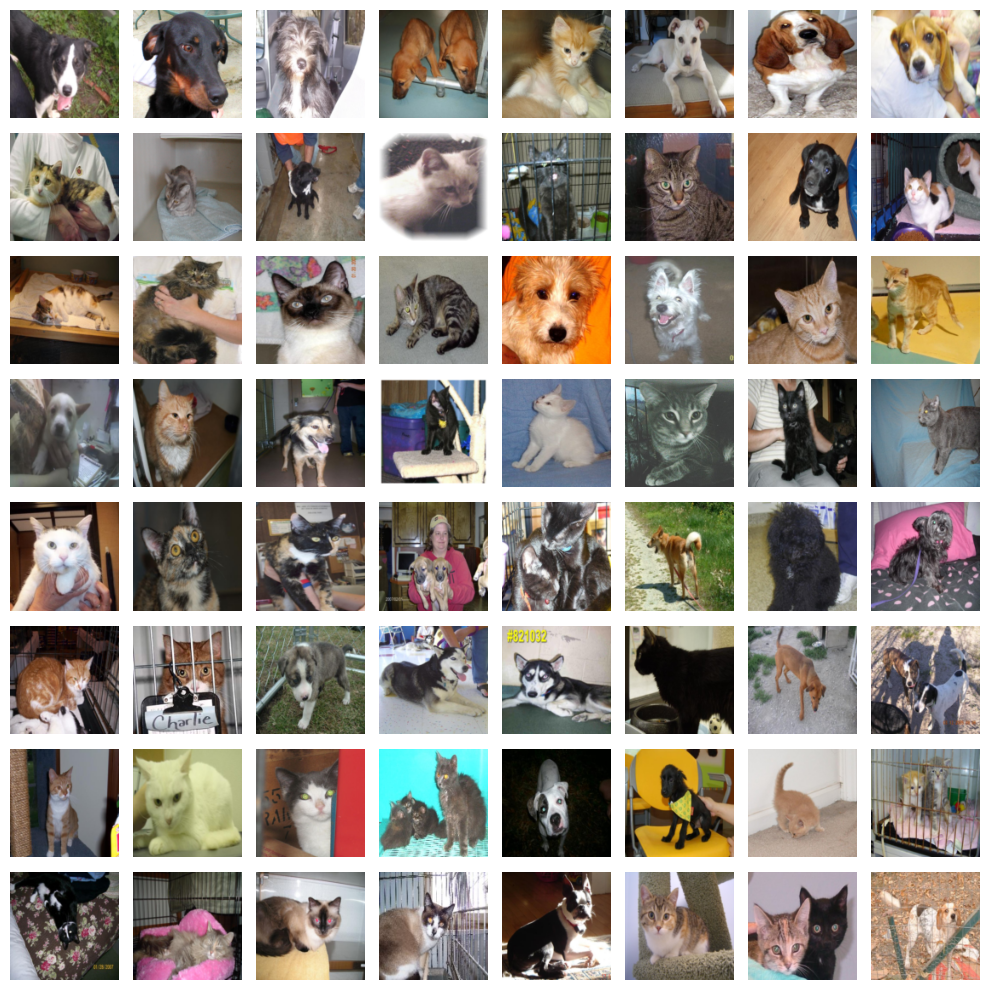

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def img_plot(img):
    plt.figure(figsize=(10,10))
    for i in range(len(img)):
        temp_img = img[i].numpy()
        temp_img = np.transpose(temp_img, (1,2,0))  #from [C,H,W] to [H,W,C]
        plt.subplot(8,8, i+1)    #plot's index in the grid
        plt.imshow(temp_img)     #Plot the image
        plt.axis('off')
        
    plt.tight_layout()    
    plt.show()
    
dataiter = iter(train_data)
images, labels = next(dataiter)

img_plot(images)

In [60]:
model = CNN()
model = model.to(device)
output = model(images[0].to(device))  #Model testing
print(model)
print(output)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)
tensor([[0.4910]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [61]:
from torch import optim
from torch.nn import BCELoss

criterion = BCELoss()
optimizer = optim.Adam(model.parameters())

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader,0):
        inputs, labels = inputs.to(device), labels.to(device).float()

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs).reshape(-1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute statistics
        train_loss += loss.item() * inputs.size(0)  # Add up the loss
        predicted = (outputs>=0.5).float()        # Get predictions
        correct += (predicted == labels).sum().item()  # Count correct predictions
        total += labels.size(0)                    # Count total labels

    # Calculate average training loss and accuracy
    avg_train_loss = train_loss / total
    train_accuracy = correct / total

    return avg_train_loss, train_accuracy


def test_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device).float()

            outputs = model(inputs).reshape(-1)
            loss = criterion(outputs, labels)

            # Compute statistics
            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs>=0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / total
    val_accuracy = correct / total

    return avg_val_loss, val_accuracy


In [62]:
epochs = 20

for epoch in range(epochs):
    training_loss, training_accuracy = train_model(model, train_data, criterion, optimizer, device)
    validation_loss, validation_accuracy = test_model(model, validation_data, criterion, device)
    print(f'# Epoch {epoch+1}: Training Loss {training_loss:.3f}  Training Accuracy {training_accuracy:.3f} Validation Loss {validation_loss:.3f}  Validation Accuracy {validation_accuracy:.3f}')

# Epoch 1: Training Loss 0.703  Training Accuracy 0.502 Validation Loss 0.688  Validation Accuracy 0.500
# Epoch 2: Training Loss 0.690  Training Accuracy 0.531 Validation Loss 0.683  Validation Accuracy 0.604
# Epoch 3: Training Loss 0.661  Training Accuracy 0.610 Validation Loss 0.633  Validation Accuracy 0.612
# Epoch 4: Training Loss 0.613  Training Accuracy 0.676 Validation Loss 0.672  Validation Accuracy 0.582
# Epoch 5: Training Loss 0.568  Training Accuracy 0.713 Validation Loss 0.567  Validation Accuracy 0.701
# Epoch 6: Training Loss 0.535  Training Accuracy 0.739 Validation Loss 0.579  Validation Accuracy 0.690
# Epoch 7: Training Loss 0.500  Training Accuracy 0.760 Validation Loss 0.591  Validation Accuracy 0.703
# Epoch 8: Training Loss 0.463  Training Accuracy 0.779 Validation Loss 0.558  Validation Accuracy 0.735
# Epoch 9: Training Loss 0.431  Training Accuracy 0.807 Validation Loss 0.605  Validation Accuracy 0.704
# Epoch 10: Training Loss 0.405  Training Accuracy 0.81